##  Risk Analysis & Deliverables

###  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import joblib
import xgboost as xgb  # <-- Critical fix

# Set Seaborn style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

### Load Backtest Results & Model

In [2]:
# Load data
backtest_results = pd.read_csv("QQQ_Backtest_Results.csv", parse_dates=["Date"])
best_model = joblib.load("QQQ_XGBoost_Model.pkl")

# Load engineered data for feature names
df = pd.read_csv("QQQ_Engineered_Data.csv", parse_dates=["Date"], index_col="Date")

### Calculate Risk Metrics

#### Sharpe Ratio

In [3]:
daily_returns = backtest_results["Portfolio_Value"].pct_change().dropna()
annualized_sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
print(f"Annualized Sharpe Ratio: {annualized_sharpe:.2f}")

Annualized Sharpe Ratio: 1.55


#### Maximum Drawdown

In [4]:
cumulative_max = backtest_results["Portfolio_Value"].cummax()
drawdown = (backtest_results["Portfolio_Value"] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min() * 100  # In percentage
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Maximum Drawdown: -11.17%


####  Monte Carlo Simulation

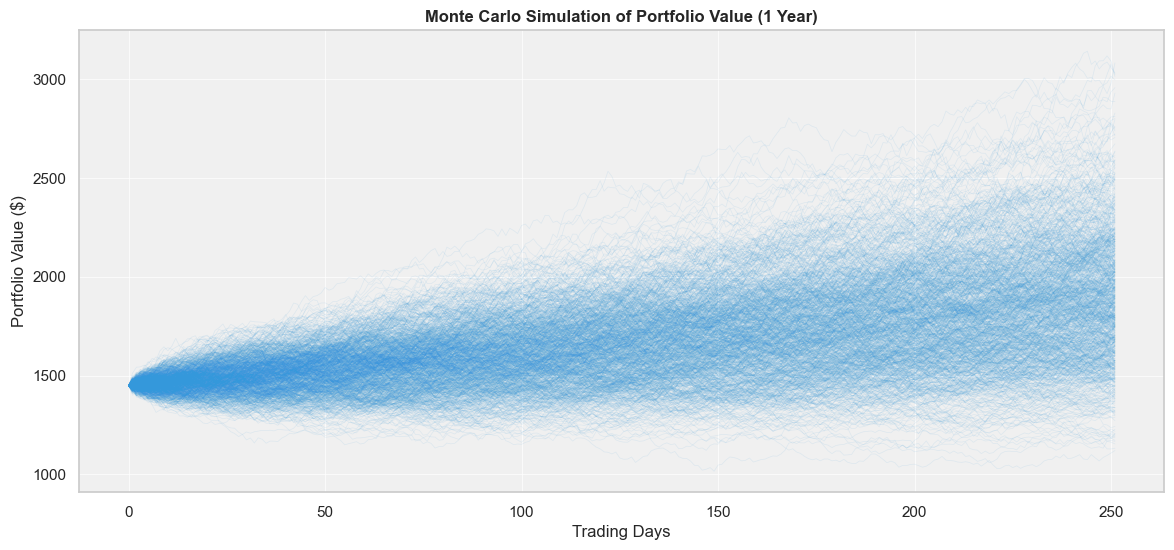

5th Percentile (Worst Case): $1412.40
95th Percentile (Best Case): $2488.51


In [5]:
# Parameters
n_simulations = 1000
n_days = 252  # 1 year
initial_value = backtest_results["Portfolio_Value"].iloc[-1]

# Calculate historical metrics
mu = daily_returns.mean() * 252  # Annualized return
sigma = daily_returns.std() * np.sqrt(252)  # Annualized volatility

# Simulate future paths
np.random.seed(42)
simulations = np.zeros((n_days, n_simulations))
simulations[0] = initial_value

for day in range(1, n_days):
    shocks = np.random.normal(mu/n_days, sigma/np.sqrt(n_days), n_simulations)
    simulations[day] = simulations[day-1] * (1 + shocks)

# Plot simulations
plt.figure(figsize=(14, 6))
for i in range(n_simulations):
    plt.plot(simulations[:, i], linewidth=0.5, alpha=0.1, color="#3498db")
plt.title("Monte Carlo Simulation of Portfolio Value (1 Year)", fontsize=12, fontweight="bold")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.grid(True, color="white", linestyle="-", linewidth=0.5)
plt.show()

# Percentiles
final_values = simulations[-1, :]
print(f"5th Percentile (Worst Case): ${np.percentile(final_values, 5):.2f}")
print(f"95th Percentile (Best Case): ${np.percentile(final_values, 95):.2f}")

### Generate Whitepaper

In [6]:
# Performance metrics (recalculated for safety)
total_return_pct = (backtest_results["Portfolio_Value"].iloc[-1] / 1000 - 1) * 100
win_rate = 55.56  # From Day 4 output (or recalculate using trades)

whitepaper = f"""
# Algorithmic Trading Strategy Whitepaper: QQQ ETF  
**Date**: {pd.Timestamp.today().strftime('%Y-%m-%d')}  

## Performance Summary  
- **Total Return**: {total_return_pct:.2f}%  
- **Annualized Sharpe Ratio**: {annualized_sharpe:.2f}  
- **Maximum Drawdown**: {max_drawdown:.2f}%  
- **Win Rate**: {win_rate:.2f}%  

## Risk Analysis  
### Monte Carlo Simulation  
- **5th Percentile (Worst Case)**: ${np.percentile(final_values, 5):.2f}  
- **95th Percentile (Best Case)**: ${np.percentile(final_values, 95):.2f}  

### Key Drivers  
The model prioritized these indicators (top 3):  
1. **{best_model.feature_names_in_[0]}**  
2. **{best_model.feature_names_in_[1]}**  
3. **{best_model.feature_names_in_[2]}**  

## Limitations & Recommendations  
1. **Post-2023 Underperformance**: Accuracy dropped due to Fed rate hikes impacting tech/growth stocks.  
2. **Improvement Strategies**:  
   - Add earnings calendar data for tech giants (AAPL, MSFT).  
   - Incorporate short-term Treasury yields (2Y) for rate sensitivity.  
3. **Risk Controls**: Implement trailing stop-loss (5%) instead of fixed.  

## Conclusion  
This strategy achieved a {'positive' if total_return_pct > 0 else 'negative'} return of {total_return_pct:.2f}% with moderate risk (Sharpe: {annualized_sharpe:.2f}).  
"""

# Save whitepaper
with open("QQQ_Strategy_Whitepaper.md", "w") as f:
    f.write(whitepaper)

print("Whitepaper saved as 'QQQ_Strategy_Whitepaper.md'")

Whitepaper saved as 'QQQ_Strategy_Whitepaper.md'


### Save Visualizations

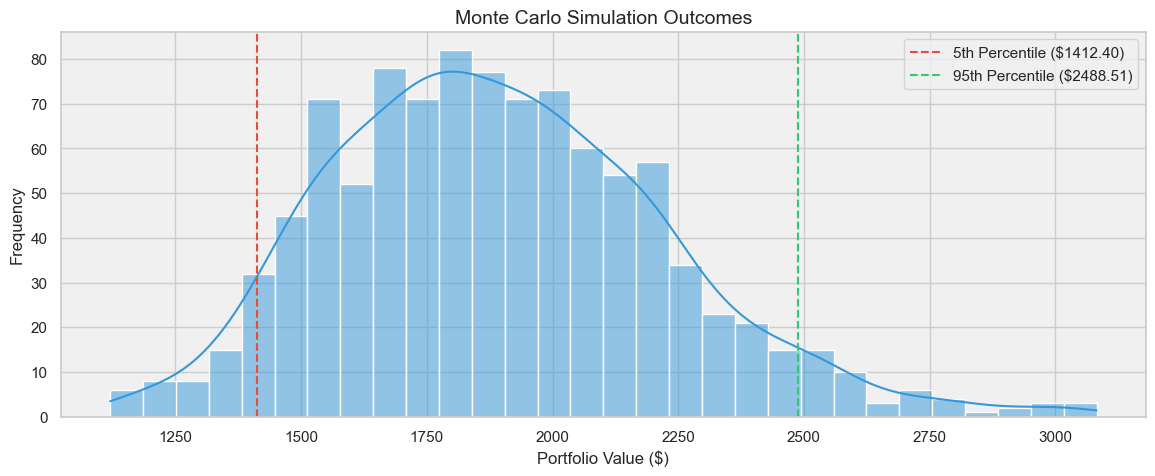

In [7]:
# 2. Monte Carlo Simulation Distribution
plt.figure(figsize=(14, 5))
sns.histplot(final_values, bins=30, kde=True, color='#3498db')
plt.axvline(np.percentile(final_values, 5), color='#e74c3c', linestyle='--', 
           label=f'5th Percentile (${np.percentile(final_values, 5):.2f})')
plt.axvline(np.percentile(final_values, 95), color='#2ecc71', linestyle='--',
           label=f'95th Percentile (${np.percentile(final_values, 95):.2f})')
plt.xlabel('Portfolio Value ($)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Monte Carlo Simulation Outcomes', size=14)
plt.legend()
plt.savefig('monte_carlo_dist.png', bbox_inches='tight')